In [309]:
%pylab inline 
import pickle
import tensorflow as tf
import flowpm
from flowpm.tfpower import linear_matter_power
import DifferentiableHOS as DHOS
import os
import jax_cosmo as jc
import jax_cosmo.power as power
from astropy.cosmology import Planck15
from flowpm.utils import cic_paint, compensate_cic
from flowpm.tfpower import linear_matter_power

Populating the interactive namespace from numpy and matplotlib


/global/common/software/nersc/shasta2105/tensorflow/2.6.0/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['figsize', 'f', 'power']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [310]:
#Below are a few parameters
box_size = 205.   # Transverse comoving size of the simulation volume
field_size = 5    # Size of the lensing field in degrees
field_npix = 1024 # Number of pixels in the lensing field
z_source=tf.convert_to_tensor([1.034,0.858,1.163],dtype=tf.float32)

In [3]:
states=[]
states_nopgd=[]
initial_conditions=[]
for filename in os.listdir("/pscratch/sd/d/dlan/maps_noia/maps1/"):
        f=open(os.path.join('/pscratch/sd/d/dlan/maps_noia/maps1/', filename), 'rb')
        res1 =pickle.load(f)
        states.append(res1['states'])
        states_nopgd.append(res1['states_nopgd'])
        initial_conditions.append(res1['initial_conditions'])
        f.close()

In [5]:
for filename in os.listdir("/pscratch/sd/d/dlan/maps_noia/maps2/"):
        f=open(os.path.join('/pscratch/sd/d/dlan/maps_noia/maps2/', filename), 'rb')
        res1 =pickle.load(f)
        states.append(res1['states'])
        states_nopgd.append(res1['states_nopgd'])
        initial_conditions.append(res1['initial_conditions'])
        f.close()

In [88]:
a=[0.23569357, 0.37138715, 0.50708073, 0.5226171 , 0.55492735,
       0.5890392 , 0.6254705 , 0.66399264, 0.7050982 , 0.7491416 ,
       0.79699695, 0.8485536 , 0.904651  , 0.96678156]

In [46]:
cosmo=jc.Planck15()

In [89]:
pk_target=[]
for i in range(14):
    target_pk = power.nonlinear_matter_power(cosmo, k, a[i])
    pk_target.append(target_pk)

/global/homes/d/dlan/.local/perlmutter/tensorflow2.6.0/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6623: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [ ]:
pk_nopgd_ar=[]
pk_pgd_ar=[]
pk_target_ar=[]
for i in range(len(states)):
    print(i)
    pk_nopgd=[]
    pk_pgd=[]
    for j in range(len(states[i])):
        field = flowpm.cic_paint(tf.zeros_like(initial_conditions[i]), states_nopgd[i][j][0])
        field = compensate_cic(field)
        k, pk = flowpm.power_spectrum(field, boxsize=np.array([box_size] * 3),kmin=np.pi / box_size, dk=2 * np.pi / box_size)
        field_pgd = flowpm.cic_paint(tf.zeros_like(initial_conditions[i]), states[i][j][0])
        field_pgd = compensate_cic(field_pgd)
        kpgd, pkpgd = flowpm.power_spectrum(field_pgd, boxsize=np.array([box_size] * 3),kmin=np.pi / box_size, dk=2 * np.pi / box_size)
        pk_nopgd.append(pk)
        pk_pgd.append(pkpgd)
    pk_nopgd_ar.append(pk_nopgd)
    pk_pgd_ar.append(pk_pgd)
        
    
    

In [285]:
pk_nopgd_mean=np.mean(tf.stack(pk_nopgd_ar),axis=0)
pk_pgd_mean=np.mean(tf.stack(pk_pgd_ar),axis=0)

In [294]:
np.save("pk_nopgd_ar.npy",pk_nopgd_ar)
np.save("pk_pgd_ar.npy",pk_pgd_ar)

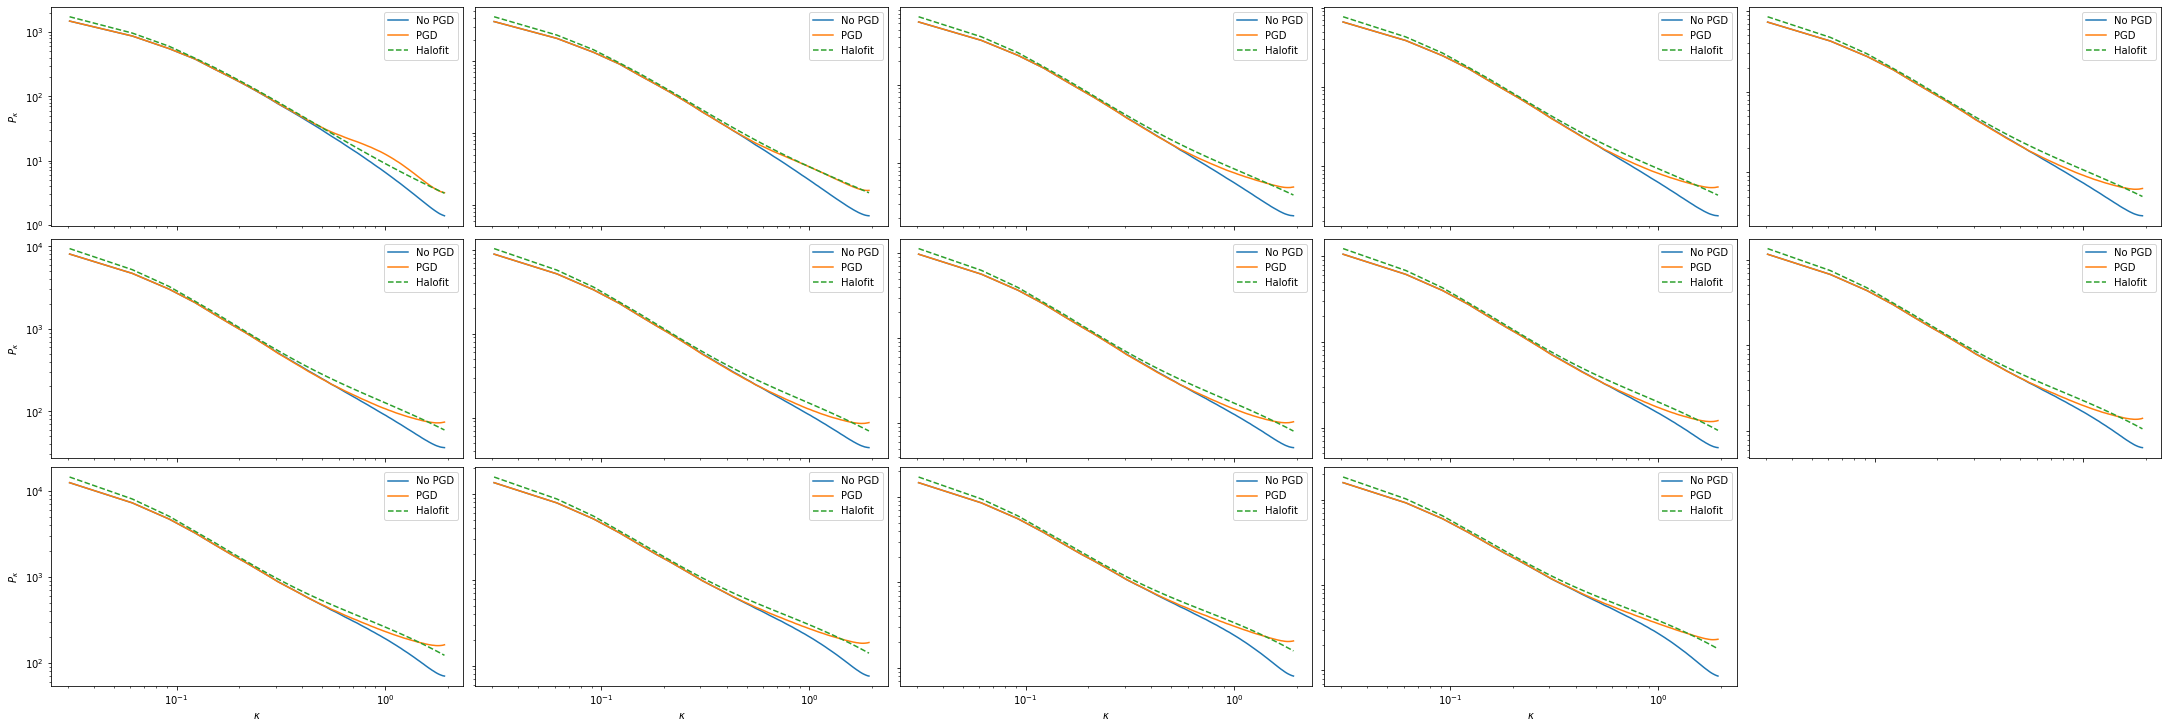

In [290]:
figsize = (30, 10)
fig =plt.figure(figsize=figsize, constrained_layout=True)
cols = 5
rows =3
ax = fig.subplots(rows, cols)
for j in range(len(states[0])):
    ax.flatten()[j].loglog(k, pk_nopgd_mean[j][0],label='No PGD')
    ax.flatten()[j].loglog(k, pk_pgd_mean[j][0],label='PGD')
    ax.flatten()[j].loglog(k, pk_target[j],'--',label='Halofit')
    ax.flatten()[j].set(xlabel=r'$\kappa$', ylabel=r'$P_{\kappa}$')
    ax.flatten()[j].legend()
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.flatten()[j].label_outer()
ax.flatten()[14].remove()


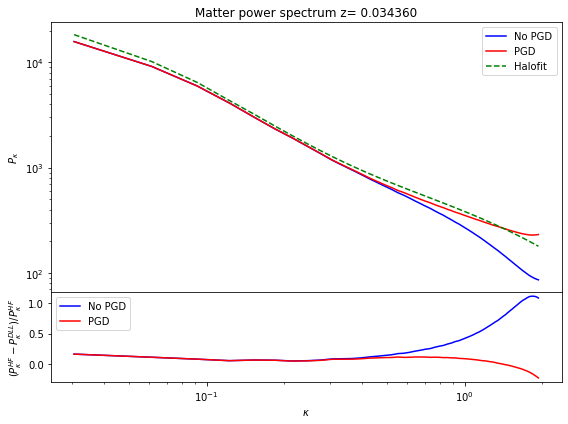

In [307]:
from matplotlib import gridspec
#style.use('seaborn-whitegrid')
# plot it
fig = plt.figure(figsize=(8, 6))
j=-1
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1],hspace=0) 
ax0 = plt.subplot(gs[0])
ax0.loglog(k, pk_nopgd_mean[j][0],label='No PGD',color='blue')
ax0.loglog(k, pk_pgd_mean[j][0],label='PGD',color='red')
ax0.loglog(k, pk_target[j],'--',label='Halofit',color='green')
ax0.set_title('Matter power spectrum z= %f' %(1/a[j]-1))
plt.legend()
ax1 = plt.subplot(gs[1])
ax1.plot(k, pk_target[j]/pk_nopgd_mean[j][0]-1,label='No PGD',color='blue')
ax1.plot(k, pk_target[j]/pk_pgd_mean[j][0]-1,label='PGD',color='red')
ax1.set_xscale('log')
plt.legend()

ax0.set_ylabel('$P_{\kappa}$')
ax1.set_ylabel('$(P_{\kappa}^{HF}-P_{\kappa}^{DLL})/P_{\kappa}^{HF}$')
ax1.set_xlabel('$\kappa$')
plt.tight_layout()


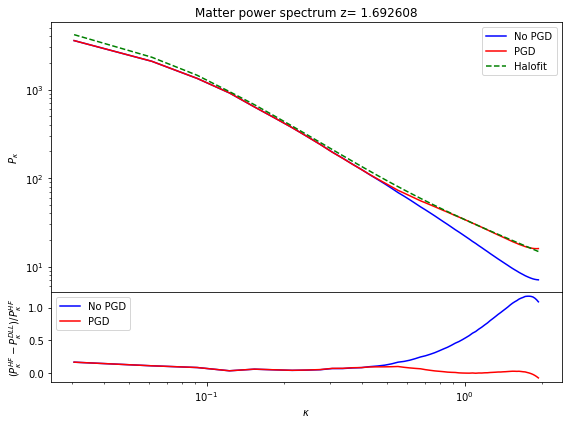

In [308]:
from matplotlib import gridspec
#style.use('seaborn-whitegrid')
# plot it
fig = plt.figure(figsize=(8, 6))
j=1
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1],hspace=0) 
ax0 = plt.subplot(gs[0])
ax0.loglog(k, pk_nopgd_mean[j][0],label='No PGD',color='blue')
ax0.loglog(k, pk_pgd_mean[j][0],label='PGD',color='red')
ax0.loglog(k, pk_target[j],'--',label='Halofit',color='green')
ax0.set_title('Matter power spectrum z= %f' %(1/a[j]-1))
plt.legend()
ax1 = plt.subplot(gs[1])
ax1.plot(k, pk_target[j]/pk_nopgd_mean[j][0]-1,label='No PGD',color='blue')
ax1.plot(k, pk_target[j]/pk_pgd_mean[j][0]-1,label='PGD',color='red')
ax1.set_xscale('log')
plt.legend()

ax0.set_ylabel('$P_{\kappa}$')
ax1.set_ylabel('$(P_{\kappa}^{HF}-P_{\kappa}^{DLL})/P_{\kappa}^{HF}$')
ax1.set_xlabel('$\kappa$')
plt.tight_layout()


In [311]:
ps_pgd_r=[]
ps_nopgd_r=[]
for filename in os.listdir("/pscratch/sd/d/dlan/maps_noia/maps1/"):
        f=open(os.path.join('/pscratch/sd/d/dlan/maps_noia/maps1/', filename), 'rb')
        res1 =pickle.load(f)
        km=res1['m']
        km_nopgd=res1['m_nopgd']
        f.close()
        ps_pgd=[]
        ps_nopgd=[]
        for j in range(3):
            l,p=DHOS.statistics.power_spectrum(km[j],field_size,field_npix) 
            l,pp= DHOS.statistics.power_spectrum(km_nopgd[j],field_size,field_npix)
            ps_pgd.append(p)
            ps_nopgd.append(pp)   
        ps_pgd_r.append(ps_pgd)
        ps_nopgd_r.append(ps_nopgd)

In [312]:
for filename in os.listdir("/pscratch/sd/d/dlan/maps_noia/maps2/"):
        f=open(os.path.join('/pscratch/sd/d/dlan/maps_noia/maps2/', filename), 'rb')
        res1 =pickle.load(f)
        km=res1['m']
        km_nopgd=res1['m_nopgd']
        f.close()
        ps_pgd=[]
        ps_nopgd=[]
        for j in range(3):
            l,p=DHOS.statistics.power_spectrum(km[j],field_size,field_npix) 
            l,pp= DHOS.statistics.power_spectrum(km_nopgd[j],field_size,field_npix)
            ps_pgd.append(p)
            ps_nopgd.append(pp)   
        ps_pgd_r.append(ps_pgd)
        ps_nopgd_r.append(ps_nopgd)

In [313]:
ps_r_mean=np.mean(ps_pgd_r,axis=0)
ps_nopgd_r_mean=np.mean(ps_nopgd_r,axis=0)

In [314]:
cosmo=jc.Planck15()

In [315]:
cls_t=[]
for i in range(3):
    nz =jc.redshift.delta_nz(z_source[i].numpy())
    probes = [jc.probes.WeakLensing([nz])] 
    cls_t.append(jc.angular_cl.angular_cl(cosmo, l.numpy(), probes))

/global/homes/d/dlan/.local/perlmutter/tensorflow2.6.0/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6623: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [239]:
np.save("cls_mean.npy",ps_r_mean)
np.save("cls_nopgd_mean.npy",ps_nopgd_r_mean)
np.save("cls_halofit.npy",cls_t)

### Redshift 1.034

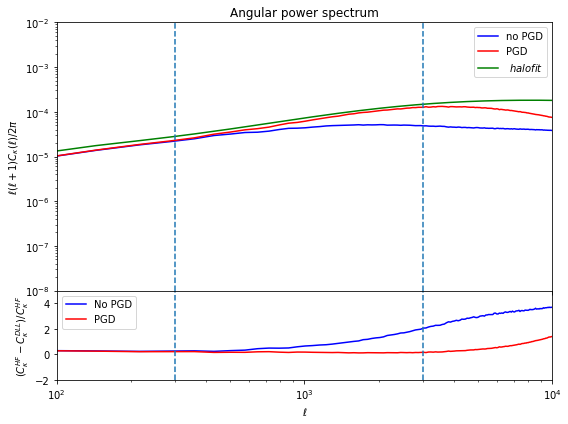

In [316]:
from matplotlib import gridspec

fig = plt.figure(figsize=(8, 6))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1],hspace=0) 
ax0 = plt.subplot(gs[0])
ax0.loglog(l, l*(l+1)*ps_nopgd_r_mean[0]/(2*np.pi),label='no PGD',color='blue')
ax0.loglog(l, l*(l+1)*ps_r_mean[0]/(2*np.pi),label='PGD',color='red')
ax0.loglog(l, l*(l+1)*cls_t[0][0]/(2*np.pi),label=' $halofit$',color='green')
ax0.set_title('Angular power spectrum')
ax0.set_xlim(1e2,1e4)
ax0.set_ylim(1e-8,1e-2)
ax0.label_outer()
ax0.set_ylabel('$\ell(\ell+1)C_{\kappa}(\ell) /2\pi$')
plt.legend()
axvline(300,ls='--')
axvline(3000,ls='--')
ax1 = plt.subplot(gs[1])
ax1.plot(l, cls_t[0][0]/ps_nopgd_r_mean[0]-1,label='No PGD',color='blue')
ax1.plot(l, cls_t[0][0]/ps_r_mean[0]-1,label='PGD',color='red')
ax1.set_xscale('log')
plt.legend()
ax1.set_xlim(1e2,1e4)
ax1.set_ylabel('$(C_{\kappa}^{HF}-C_{\kappa}^{DLL})/C_{\kappa}^{HF}$')
ax1.set_xlabel('$\ell$')
ax1.set_ylim(-2,5)
axvline(300,ls='--')
axvline(3000,ls='--')
plt.tight_layout()


### Redshift 0.858

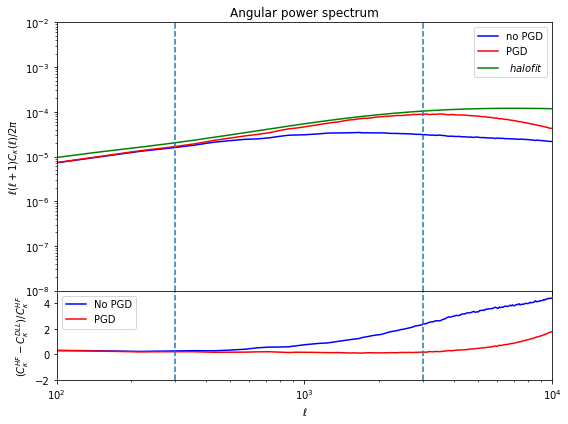

In [317]:


fig = plt.figure(figsize=(8, 6))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1],hspace=0) 
ax0 = plt.subplot(gs[0])
ax0.loglog(l, l*(l+1)*ps_nopgd_r_mean[1]/(2*np.pi),label='no PGD',color='blue')
ax0.loglog(l, l*(l+1)*ps_r_mean[1]/(2*np.pi),label='PGD',color='red')
ax0.loglog(l, l*(l+1)*cls_t[1][0]/(2*np.pi),label=' $halofit$',color='green')
ax0.set_title('Angular power spectrum')
ax0.set_xlim(1e2,1e4)
ax0.set_ylim(1e-8,1e-2)
ax0.label_outer()
ax0.set_ylabel('$\ell(\ell+1)C_{\kappa}(\ell) /2\pi$')
plt.legend()
axvline(300,ls='--')
axvline(3000,ls='--')
ax1 = plt.subplot(gs[1])
ax1.plot(l, cls_t[1][0]/ps_nopgd_r_mean[1]-1,label='No PGD',color='blue')
ax1.plot(l, cls_t[1][0]/ps_r_mean[1]-1,label='PGD',color='red')
ax1.set_xscale('log')
plt.legend()
ax1.set_xlim(1e2,1e4)
ax1.set_ylabel('$(C_{\kappa}^{HF}-C_{\kappa}^{DLL})/C_{\kappa}^{HF}$')
ax1.set_xlabel('$\ell$')
ax1.set_ylim(-2,5)
axvline(300,ls='--')
axvline(3000,ls='--')
plt.tight_layout()

### Redshift 1.163

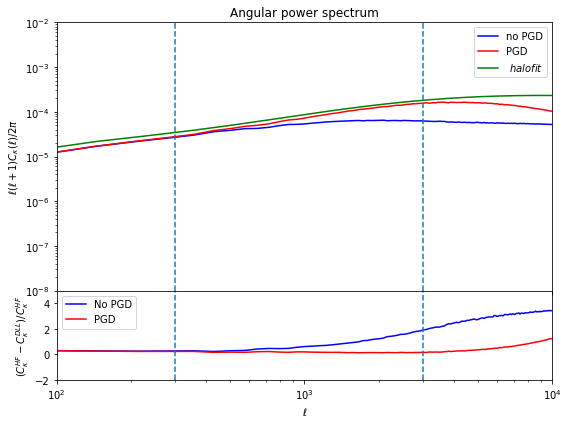

In [318]:


fig = plt.figure(figsize=(8, 6))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1],hspace=0) 
ax0 = plt.subplot(gs[0])
ax0.loglog(l, l*(l+1)*ps_nopgd_r_mean[2]/(2*np.pi),label='no PGD',color='blue')
ax0.loglog(l, l*(l+1)*ps_r_mean[2]/(2*np.pi),label='PGD',color='red')
ax0.loglog(l, l*(l+1)*cls_t[2][0]/(2*np.pi),label=' $halofit$',color='green')
ax0.set_title('Angular power spectrum')
ax0.set_xlim(1e2,1e4)
ax0.set_ylim(1e-8,1e-2)
ax0.label_outer()
ax0.set_ylabel('$\ell(\ell+1)C_{\kappa}(\ell) /2\pi$')
plt.legend()
axvline(300,ls='--')
axvline(3000,ls='--')
ax1 = plt.subplot(gs[1])
ax1.plot(l, cls_t[2][0]/ps_nopgd_r_mean[2]-1,label='No PGD',color='blue')
ax1.plot(l, cls_t[2][0]/ps_r_mean[2]-1,label='PGD',color='red')
ax1.set_xscale('log')
plt.legend()
ax1.set_xlim(1e2,1e4)
ax1.set_ylabel('$(C_{\kappa}^{HF}-C_{\kappa}^{DLL})/C_{\kappa}^{HF}$')
ax1.set_xlabel('$\ell$')
ax1.set_ylim(-2,5)
axvline(300,ls='--')
axvline(3000,ls='--')
plt.tight_layout()